### A simple Neural Network, using toylib!
We repeat the same exercise that we did previously for learning jax, but building `toylib` along this time around!

In [5]:
import jax

from toylib.nn import layers

In [6]:
key = jax.random.PRNGKey(seed=10)

We set up a simple regression problem. The problem is not very meaningful to solve by itself using such a model, but it allows us to get all the pieces in place.

In [7]:
import numpy as np
# problem setup
n = 120  # examlpes
d = 10  # dimension

# dummy data
xs = np.random.normal(size=(n, d))
weights_true = np.random.randint(0, 10, size=(d,))
ys = np.dot(xs, weights_true) + np.random.normal(size=(n,))

xs_train, xs_test = xs[:100], xs[100:]
ys_train, ys_test = ys[:100], ys[100:]
print(weights_true)

[8 0 1 7 6 3 0 9 8 5]


Our dummy `ys` are a linear transformation of the inputs. Let's try to fit a model on the train set to predict the values in the test set.

In [8]:
# @jax.jit
def loss_function(model, xs, ys):
    preds = jax.numpy.squeeze(jax.vmap(model)(xs))
    return jax.numpy.mean((ys - preds) ** 2)  # L2 Loss

In [9]:
model = layers.Linear(d, 1, use_bias=False, key=key)

We encounter another jax specific error here. The jax.jit function works specficially on pytrees, but the class that we defined is not interpretable as one.

We need to fix this.

We follow the startegy defined in https://jax.readthedocs.io/en/latest/faq.html#strategy-3-making-customclass-a-pytree. There are other ways to achieve this and altogether different design options possible, we just choose this as a simple and flexible way to make progress.


We rely on the abstract class `Module` and register it as a pytree node class.

The class needs to distinguish between the `dynamic` elements (which need to interact with jax via `jit` & `grad`) vs the `static` elements:
- Hyperparameters (like layer sizes) will be static
- The actual weight arrays will be dynamic

This is very doable for a single class by manually definiing each of these.

For making this more generally useful, we define some helper functions to make a general `pytree` class that is understood by jax.

We make some simplifying assumptions here:
- All jax or numpy arrays in the modules will be parameters
- Everything else is a hyperparameter to be treated as aux data.

Some things are still unclear: what happens with nested modules?
We shall deal with these at a later point.


Now that we have a basic `Linear` module, we can define our first forward-backward pass using the `jax.value_and_grad` function.


In [10]:
loss, grads = jax.value_and_grad(loss_function)(model, xs, ys)

The `grads` is now also an object of the same type `Linear`. This is because jax now treats `Linear` objects as
pytree nodes. For each applicable child in the node, it will produce a grad.

Once we have the grads, we still need to update the original model parameters.

Here, we simply use `theta_new` = `theta` - `alpha * grads`

In [11]:
def apply_update(model, grads, learning_rate):
    return jax.tree_map(lambda x, y: x - learning_rate * y, model, grads)

In [12]:
weights_true

array([8, 0, 1, 7, 6, 3, 0, 9, 8, 5])

In [13]:
model.tree_flatten()

([('weights',
   Array([[ 0.12969103, -0.09365288, -0.2750842 , -0.30919993,  0.22844149,
            0.15211436, -0.11285052,  0.04825569, -0.07129356, -0.1104468 ]],      dtype=float32))],
 {'aux': {'in_features': 10,
   'out_features': 1,
   'use_bias': False,
   'key': Array([ 0, 10], dtype=uint32)},
  'dynamic_keys': ['weights']})

In [14]:
grads.weights

Array([[-14.781862 ,  -1.9253446,  -2.2385614, -13.486185 ,  -8.770853 ,
         -8.331986 ,   1.5873729, -22.667734 , -10.61196  , -10.05963  ]],      dtype=float32)

In [15]:
## training loop
# initial estimates

# hyperparmeters
max_steps = 100
learning_rate = 0.1

step = 0

# until we reach max_steps or the loss doesn't change by <eps>
while step < max_steps:
    # compute model value and grad
    loss, grads = jax.value_and_grad(loss_function)(model, xs, ys)
    print(loss)
    print(model.weights)
    print(grads.weights)
    model = apply_update(model, grads, learning_rate)
    print(model.weights)

    step += 1
    # break

317.49124
[[ 0.12969103 -0.09365288 -0.2750842  -0.30919993  0.22844149  0.15211436
  -0.11285052  0.04825569 -0.07129356 -0.1104468 ]]
[[-14.781862   -1.9253446  -2.2385614 -13.486185   -8.770853   -8.331986
    1.5873729 -22.667734  -10.61196   -10.05963  ]]
[[ 1.6078773   0.09888158 -0.05122806  1.0394186   1.1055268   0.98531306
  -0.27158782  2.3150291   0.9899025   0.8955163 ]]
202.70085
[[ 1.6078773   0.09888158 -0.05122806  1.0394186   1.1055268   0.98531306
  -0.27158782  2.3150291   0.9899025   0.8955163 ]]
[[-11.86194     -1.1104586   -1.4869794  -10.830417    -7.301069
   -6.078191     0.80513805 -17.010199    -9.453131    -8.099378  ]]
[[ 2.7940712   0.20992744  0.09746988  2.1224604   1.8356338   1.5931321
  -0.35210162  4.016049    1.9352156   1.7054541 ]]
131.34358
[[ 2.7940712   0.20992744  0.09746988  2.1224604   1.8356338   1.5931321
  -0.35210162  4.016049    1.9352156   1.7054541 ]]
[[ -9.530068    -0.59339786  -1.0134875   -8.741027    -6.1020756
   -4.4122033    

In [16]:
weights_true

array([8, 0, 1, 7, 6, 3, 0, 9, 8, 5])

In [17]:
model.weights

Array([[ 7.894796  ,  0.13690166,  0.98269093,  7.066006  ,  5.949501  ,
         3.1033916 , -0.13549761,  9.016399  ,  8.120163  ,  4.9188857 ]],      dtype=float32)

Matplotlib is building the font cache; this may take a moment.


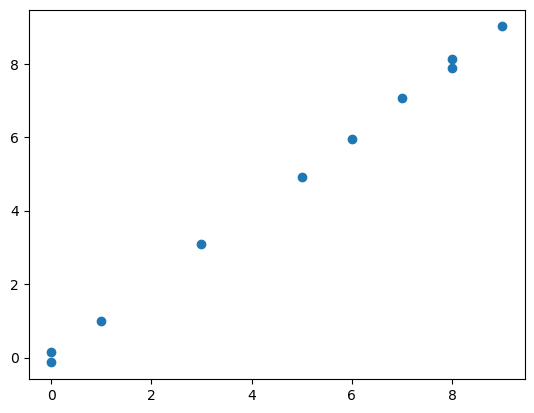

In [18]:
import matplotlib.pyplot as plt

plt.scatter(weights_true, model.weights.ravel())